In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import random
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import make_lupton_rgb

plt.style.use('dark_background')

In [2]:
class ImageDataset(Dataset):
    """Dataset of Images and Labels"""

    def __init__(self, images, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = np.array(self.labels[idx])
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [3]:
class CNN(nn.Module):
    """
    Convolutional Neural Network for multiband data. Note that you
    will need to update the number of in_features for self.fc3.
    """
    def __init__(self, in_channels, num_classes):
        """
		Args:
		    in_channels: number of bands (gri = 3, griz=4)
			num_classes: number of unique labels in your dataset
		"""
        super(CNN, self).__init__()
        
        #Network Components
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                               out_channels=48, 
                               kernel_size=15, 
                               stride=3,
                               padding=2)

        self.conv2 = nn.Conv2d(in_channels=48, 
                               out_channels=96,
                               kernel_size=5, 
                               stride=1,
                               padding=2)
        
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.dropout2 = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear(in_features=3456, 
                             out_features=408)

        self.fc2 = nn.Linear(in_features=408, 
                             out_features=25)

        self.fc3 = nn.Linear(in_features=25, 
                             out_features=num_classes)


    def forward(self, x):
        #Network Flow
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

    def init_weights(self, m):
        if (type(m) == nn.Linear or type(m) == nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

In [4]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors"""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
		
		# I like to add any scaling functions here, so uncomment if desired
		#image = (image - np.min(image, axis=(-1,-2))[:,:,np.newaxis,np.newaxis]) / np.max(image - np.min(image, axis=(-1,-2))[:,:,np.newaxis,np.newaxis], axis=(-1,-2))[:,:,np.newaxis,np.newaxis]

        return {'image': torch.from_numpy(image).float(),
                'label': torch.from_numpy(label)}

In [5]:
def make_train_test_datasets(images, labels, data, test_size=0.2, transform=ToTensor()):
    """
	Make training and testing datasets
	
	Args:
	    images: 4D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    # Images
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, test_size=test_size, random_state=6, stratify=y)
    
    # Parameter data
    train_data, test_data, ttrain_labels, ttest_labels = train_test_split(
        data, labels, test_size=test_size, random_state=6, stratify=y)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_labels, transform=transform),
            ImageDataset(test_images, test_labels, transform=transform), train_data, test_data)

In [6]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues, name = 'generic'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(5,3), dpi=120)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_xticklabels(classes, fontsize=12)
    ax.set_yticklabels(classes, fontsize=12)
    ax.set_xlabel('Predicted Class', fontsize=14)
    ax.set_ylabel('True Class', fontsize=14)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize=12)
    fig.tight_layout()
    #plt.savefig(path_im + '/' + 'Confusion matrix.png', bbox_inches='tight')
    plt.show()
    return

In [7]:
cnn = CNN(in_channels=3, num_classes=2)

In [8]:
name = '14/model.pt'
name_saved_model = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/models/exp/' + name #'model.pt'
cnn = torch.load(name_saved_model)

In [9]:
# Real lenses
path_cutouts = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/real_lenses/cutouts/'
hdu_list = fits.open(path_cutouts + 'real_lenses.fits')
lenses = hdu_list[1].data 
data = hdu_list[2].data
data = data.astype([('objectid', '>f8'), ('RA', '>f8'), ('dec', '>f8'), ('grade', '>f8'), ('photoz', '>f8'), ('imag', '>f8')])
hdu_list.close()

# Negative cases
path_neg = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim_complete/negative_cases.fits'
hdu_list = fits.open(path_neg)
idx = random.sample(range(len(hdu_list[1].data)), len(lenses))
negatives = hdu_list[1].data[idx,:] 
hdu_list.close()
# Data negative cases: all null
data_neg = np.zeros((len(lenses), 6), dtype = np.float64)
names = ['objectid', 'RA', 'dec', 'grade', 'photoz', 'imag']
data_neg = Table(data = data_neg, names = names)
data_neg = fits.BinTableHDU(data = data_neg).data
data_neg = data_neg.astype([('objectid', '>f8'), ('RA', '>f8'), ('dec', '>f8'), ('grade', '>f8'), ('photoz', '>f8'), ('imag', '>f8')])


images = np.concatenate((lenses, negatives)).astype(np.float32)
labels_lenses, labels_negatives = np.zeros(len(lenses), dtype = np.int64), np.ones(len(lenses), dtype = np.int64)
labels = np.concatenate((labels_lenses, labels_negatives))
table_data = np.lib.recfunctions.stack_arrays([data, data_neg], asrecarray=True, usemask=False)

train_dataset, test_dataset, train_data, test_data = make_train_test_datasets(images, labels, table_data, test_size=0.9)
print(len(test_dataset))

918


(510, 3, 46, 46)
                                      Real lenses images


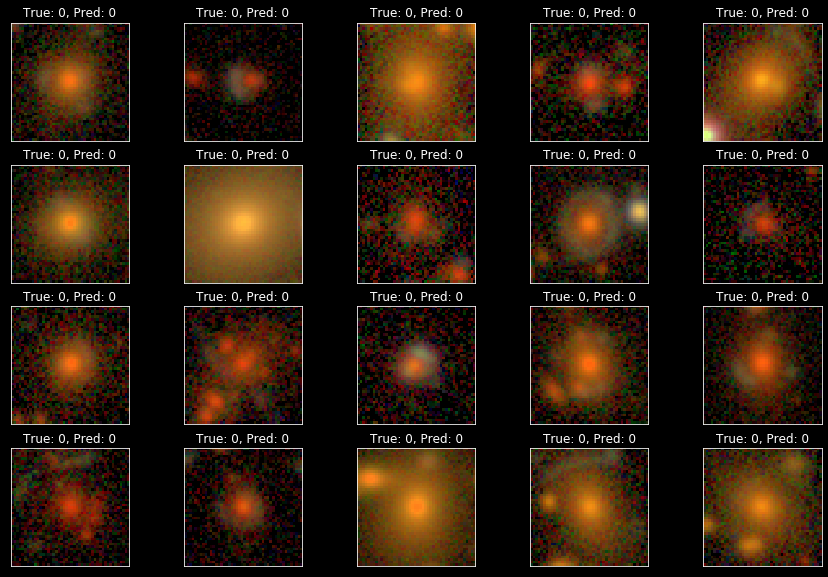

                                      Negative cases images


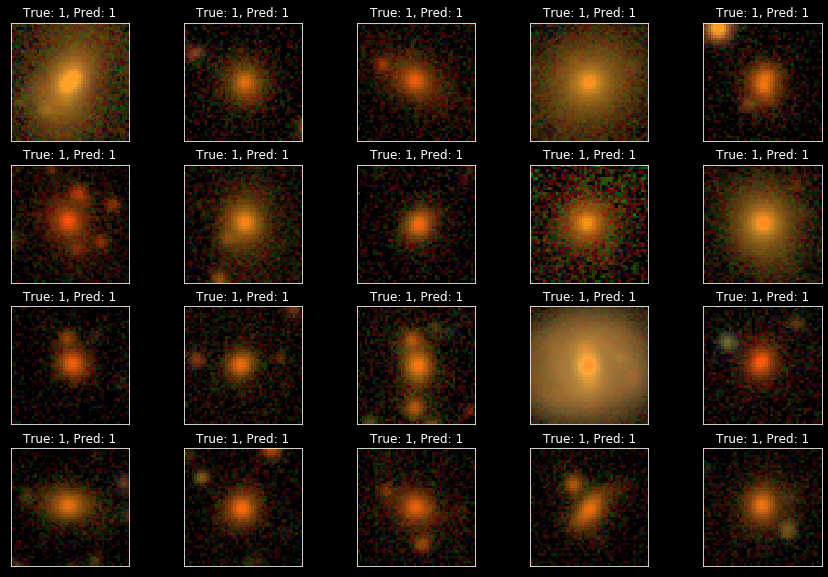

In [10]:
print(lenses.shape)

def make_plot_all(objects, true_labels, pred_labels):
    plt.figure(figsize=(15,10))
    for i in range(20):
        title = 'True: {}, Pred: {}'.format(true_labels[i], pred_labels[i])
        plt.subplot(4,5,i+1)
        plt.title(title)
        rgb = make_lupton_rgb(objects[i][2], objects[i][1], objects[i][0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.xticks([], [])
        plt.yticks([], [])
    plt.show()
  

#Here True and Pred don't have a meaning. They are all real lenses and the CNN hasn't predicted anything yet

print('                                      Real lenses images')
idx = random.sample(range(len(lenses)), 20)
objects = lenses[idx]
labels_objects = np.zeros(20, dtype = np.int64)
make_plot_all(objects, labels_objects, labels_objects)

print('                                      Negative cases images')
idx = random.sample(range(len(lenses)), 20)
objects = negatives[idx]
labels_objects = np.ones(20, dtype = np.int64)
make_plot_all(objects, labels_objects, labels_objects)

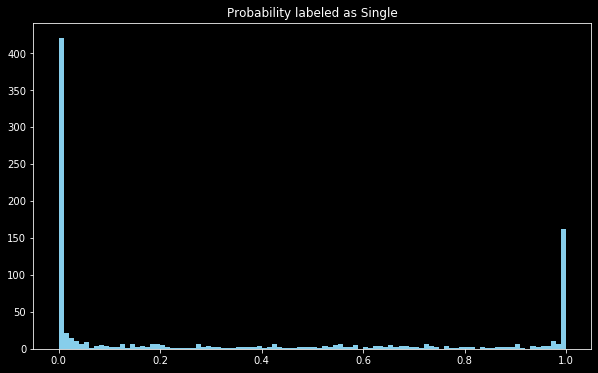

In [11]:
# Use the CNN to classify your whole test dataset
cnn.eval()
non_binary_predictions = cnn(test_dataset[:]['image'])

test_predictions = torch.max(cnn(test_dataset[:]['image']), 1)[1].data.numpy()  
test_labels = test_dataset[:]['label'].data.numpy()

m = nn.Softmax(dim=1) 
prob = (m(non_binary_predictions))
prob = prob[:,0].detach().numpy()

plt.figure(figsize=(10,6))
plt.title('Probability labeled as Single')
plt.hist(prob, 100, color = "skyblue")
plt.show()

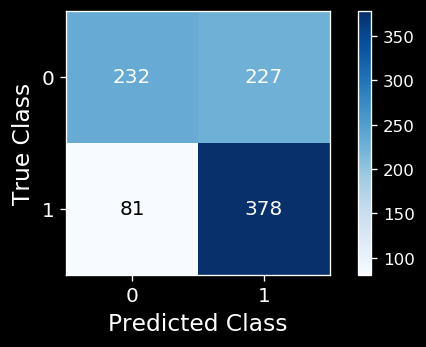

In [12]:
# Plot a confusion matrix of your results
classes = np.unique(labels)
plot_confusion_matrix(test_labels, test_predictions, classes)

In [13]:
#get indices of test dataset where the label is wrong or right predicted
ind_lenses_w, ind_lenses_r = [], []
ind_neg_w, ind_neg_r = [], []
for i in range(len(test_labels)):
    if(test_predictions[i] != test_labels[i] and test_labels[i] == 0):
        ind_lenses_w.append(i)
    elif(test_predictions[i] != test_labels[i] and test_labels[i] == 1):
        ind_neg_w.append(i)
    elif(test_predictions[i] == test_labels[i] and test_labels[i] == 0):
            ind_lenses_r.append(i)
    else:
        ind_neg_r.append(i)

Wrong lenses


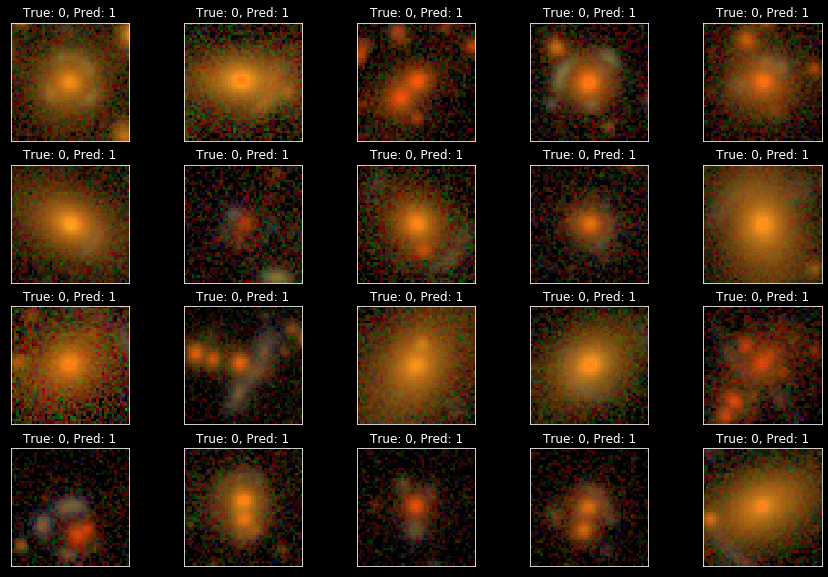

Wrong Negatives


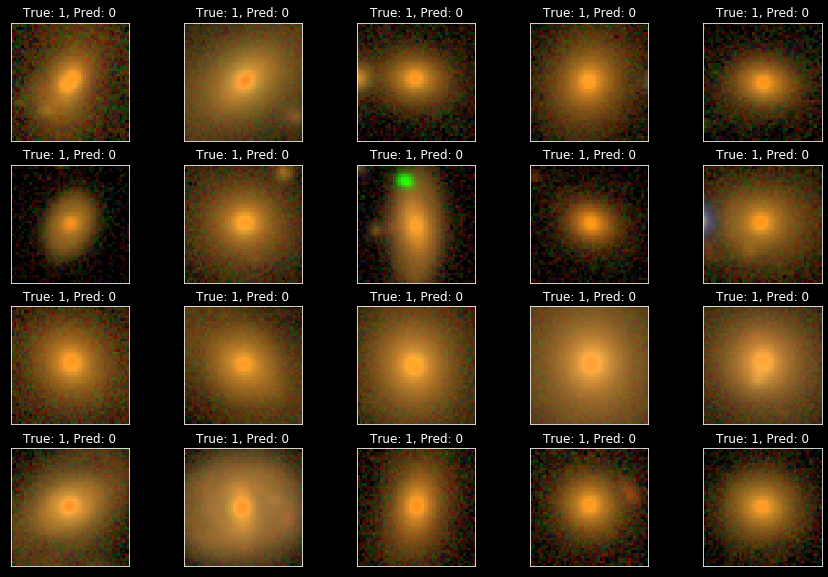

Right lenses


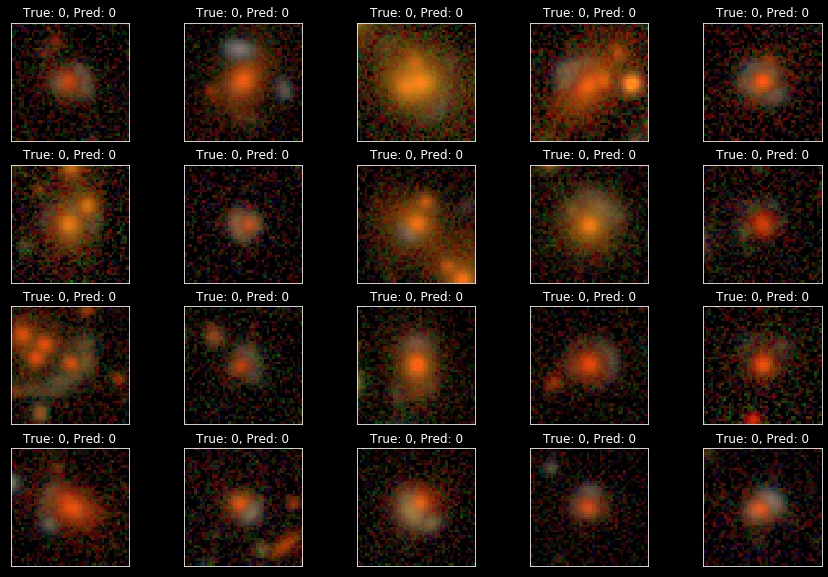

Right Negatives


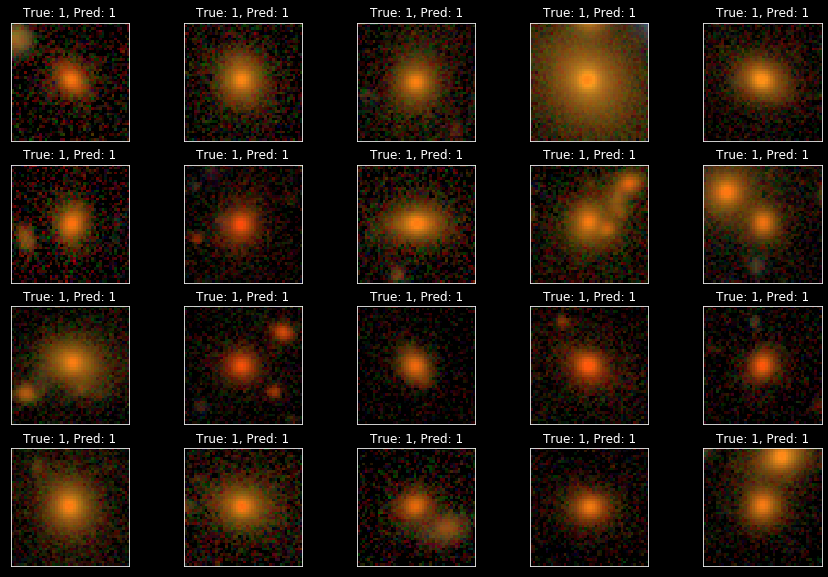

In [14]:
lenses_wrong = test_dataset.images[ind_lenses_w]
lenses_right = test_dataset.images[ind_lenses_r]
neg_wrong = test_dataset.images[ind_neg_w]
neg_right = test_dataset.images[ind_neg_r]

data_wrong_lenses = test_data[ind_lenses_w]
data_right_lenses = test_data[ind_lenses_r]

names = ['objectid', 'RA', 'dec', 'grade', 'photoz', 'imag']
titles = ['Object ID', 'RA', 'SDEC', 'Grade', 'Redshift', 'I-band apparent magnitude']

print('Wrong lenses')
idx = random.sample(range(len(lenses_wrong)), 20)
true_labels_wrong = test_labels[ind_lenses_w] # The true label
pred_labels_wrong = test_predictions[ind_lenses_w]
objects = lenses_wrong[idx]
make_plot_all(objects, true_labels_wrong, pred_labels_wrong)

print('Wrong Negatives')
idx = random.sample(range(len(neg_wrong)), 20)
true_labels_wrong = test_labels[ind_neg_w] # The true label
pred_labels_wrong = test_predictions[ind_neg_w]
objects = neg_wrong[idx]
make_plot_all(objects, true_labels_wrong, pred_labels_wrong)

print('Right lenses')
idx = random.sample(range(len(lenses_right)), 20)
true_labels_wrong = test_labels[ind_lenses_r] # The true label
pred_labels_wrong = test_predictions[ind_lenses_r]
objects = lenses_right[idx]
make_plot_all(objects, true_labels_wrong, pred_labels_wrong)

print('Right Negatives')
idx = random.sample(range(len(neg_right)), 20)
true_labels_wrong = test_labels[ind_neg_r] # The true label
pred_labels_wrong = test_predictions[ind_neg_r]
objects = neg_right[idx]
make_plot_all(objects, true_labels_wrong, pred_labels_wrong)

227 232
                                                   Distributions


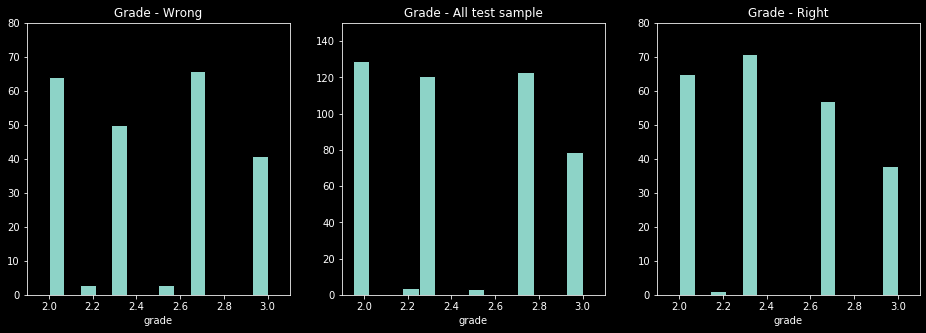

In [15]:
print(len(data_wrong_lenses), len(data_right_lenses))
# Distributions
j = 3
print('                                                   Distributions')

plt.figure(figsize=(16,5)) 
plt.subplot(1,3,1)
plt.title(titles[j] + ' - Wrong')
plt.xlim(1.9, 3.1)
plt.ylim(0, 80)
plt.xlabel(names[j])
plt.hist(data_wrong_lenses[names[j]], 14, edgecolor = 'black')
     
plt.subplot(1,3,2)
plt.title(titles[j] + ' - All test sample')
plt.xlim(1.9, 3.1)
plt.ylim(0, 150)
plt.xlabel(names[j])
plt.hist(test_data[names[j]], 40, edgecolor = 'black')
    
plt.subplot(1,3,3)
plt.title(titles[j] + ' - Right')
plt.xlim(1.9, 3.1)
plt.ylim(0, 80)
plt.xlabel(names[j])
plt.hist(data_right_lenses[names[j]], 14, edgecolor = 'black')
    
plt.show()

                                                   Distributions


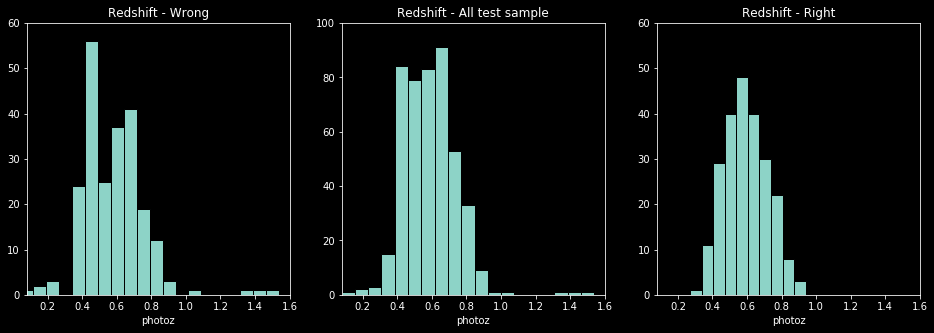

In [16]:
# Distributions
j = 4
print('                                                   Distributions')

plt.figure(figsize=(16,5)) 
plt.subplot(1,3,1)
plt.title(titles[j] + ' - Wrong')
plt.xlim(0.08, 1.6)
plt.ylim(0, 60)
plt.xlabel(names[j])
plt.hist(data_wrong_lenses[names[j]], 20, edgecolor = 'black')
     
plt.subplot(1,3,2)
plt.title(titles[j] + ' - All test sample')
plt.xlim(0.08, 1.6)
plt.ylim(0, 100)
plt.xlabel(names[j])
plt.hist(test_data[names[j]], 20, edgecolor = 'black')
    
plt.subplot(1,3,3)
plt.title(titles[j] + ' - Right')
plt.xlim(0.08, 1.6)
plt.ylim(0, 60)
plt.xlabel(names[j])
plt.hist(data_right_lenses[names[j]], 10, edgecolor = 'black')
    
plt.show()

                                                   Distributions


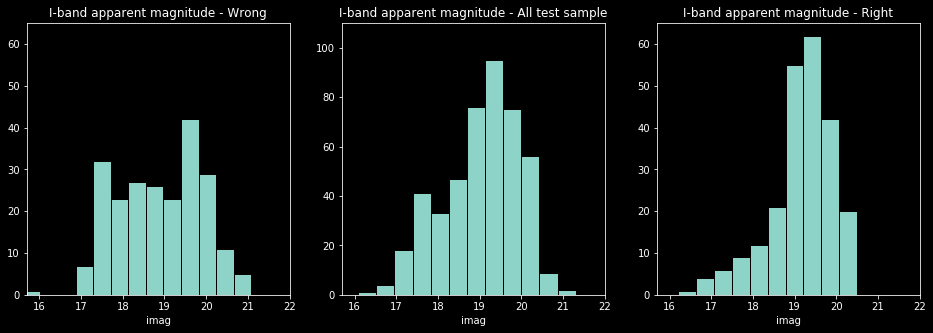

In [17]:
# Distributions
j = 5
print('                                                   Distributions')

plt.figure(figsize=(16,5)) 
plt.subplot(1,3,1)
plt.title(titles[j] + ' - Wrong')
plt.xlim(15.7, 22)
plt.ylim(0, 65)
plt.xlabel(names[j])
plt.hist(data_wrong_lenses[names[j]], 200, edgecolor = 'black')
     
plt.subplot(1,3,2)
plt.title(titles[j] + ' - All test sample')
plt.xlim(15.7, 22)
plt.ylim(0, 110)
plt.xlabel(names[j])
plt.hist(test_data[names[j]], 230, edgecolor = 'black')
    
plt.subplot(1,3,3)
plt.title(titles[j] + ' - Right')
plt.xlim(15.7, 22)
plt.ylim(0, 65)
plt.xlabel(names[j])
plt.hist(data_right_lenses[names[j]], 10, edgecolor = 'black')
    
plt.show()

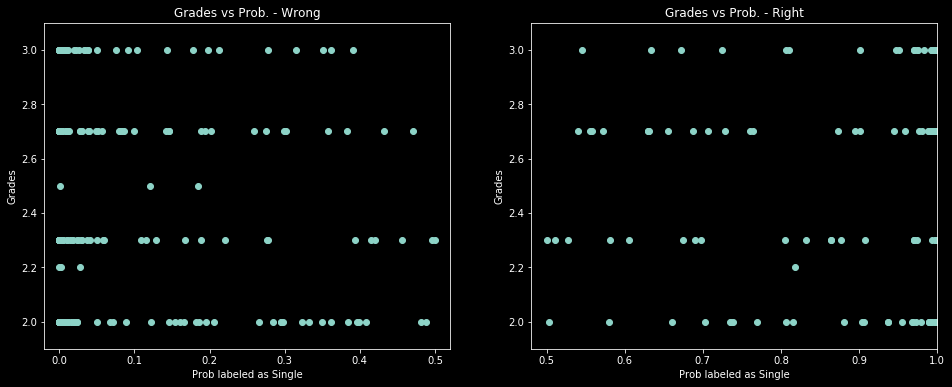

In [18]:
plt.figure(figsize=(16,6)) 

plt.subplot(1,2,1)
plt.title('Grades vs Prob. - Wrong')
plt.xlabel('Prob labeled as Single')
plt.ylabel('Grades')
plt.ylim(1.9,3.1)
plt.xlim(-0.02, 0.52)
plt.plot(prob[ind_lenses_w], data_wrong_lenses['grade'], 'o')
       
plt.subplot(1,2,2)
plt.title('Grades vs Prob. - Right')
plt.xlabel('Prob labeled as Single')
plt.ylabel('Grades')
plt.ylim(1.9,3.1)
plt.xlim(0.48, 1.0)
plt.plot(prob[ind_lenses_r], data_right_lenses['grade'], 'o')

plt.show()

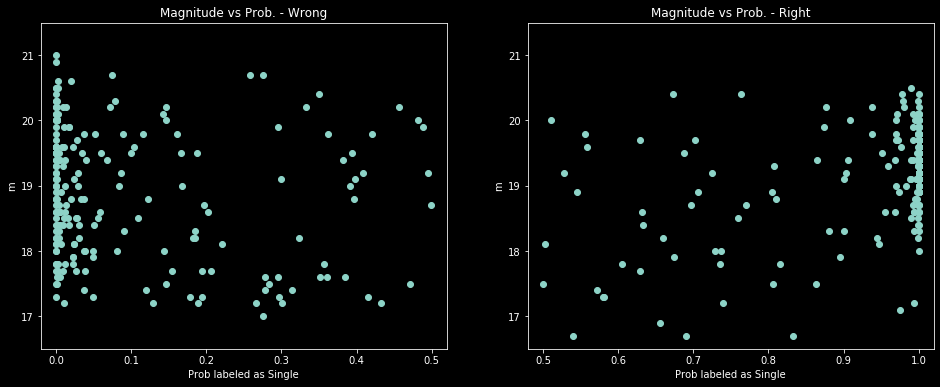

In [19]:
plt.figure(figsize=(16,6)) 

plt.subplot(1,2,1)
plt.title('Magnitude vs Prob. - Wrong')
plt.xlabel('Prob labeled as Single')
plt.ylabel('m')
plt.ylim(16.5, 21.5)
plt.xlim(-0.02, 0.52)
plt.plot(prob[ind_lenses_w], data_wrong_lenses['imag'], 'o')
       
plt.subplot(1,2,2)
plt.title('Magnitude vs Prob. - Right')
plt.xlabel('Prob labeled as Single')
plt.ylabel('m')
plt.ylim(16.5, 21.5)
plt.xlim(0.48, 1.02)
plt.plot(prob[ind_lenses_r], data_right_lenses['imag'], 'o')

plt.show()

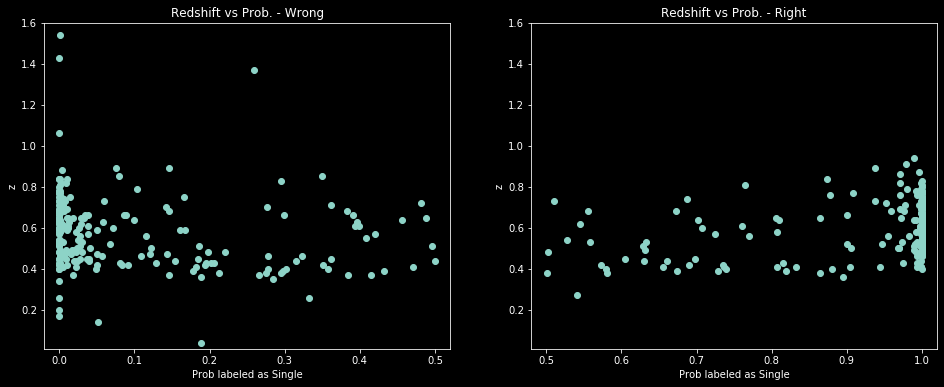

In [20]:
plt.figure(figsize=(16,6)) 

plt.subplot(1,2,1)
plt.title('Redshift vs Prob. - Wrong')
plt.xlabel('Prob labeled as Single')
plt.ylabel('z')
plt.ylim(0.01,1.6)
plt.xlim(-0.02, 0.52)
plt.plot(prob[ind_lenses_w], data_wrong_lenses['photoz'], 'o')
       
plt.subplot(1,2,2)
plt.title('Redshift vs Prob. - Right')
plt.xlabel('Prob labeled as Single')
plt.ylabel('z')
plt.ylim(0.01,1.6)
plt.xlim(0.48, 1.02)
plt.plot(prob[ind_lenses_r], data_right_lenses['photoz'], 'o')

plt.show()

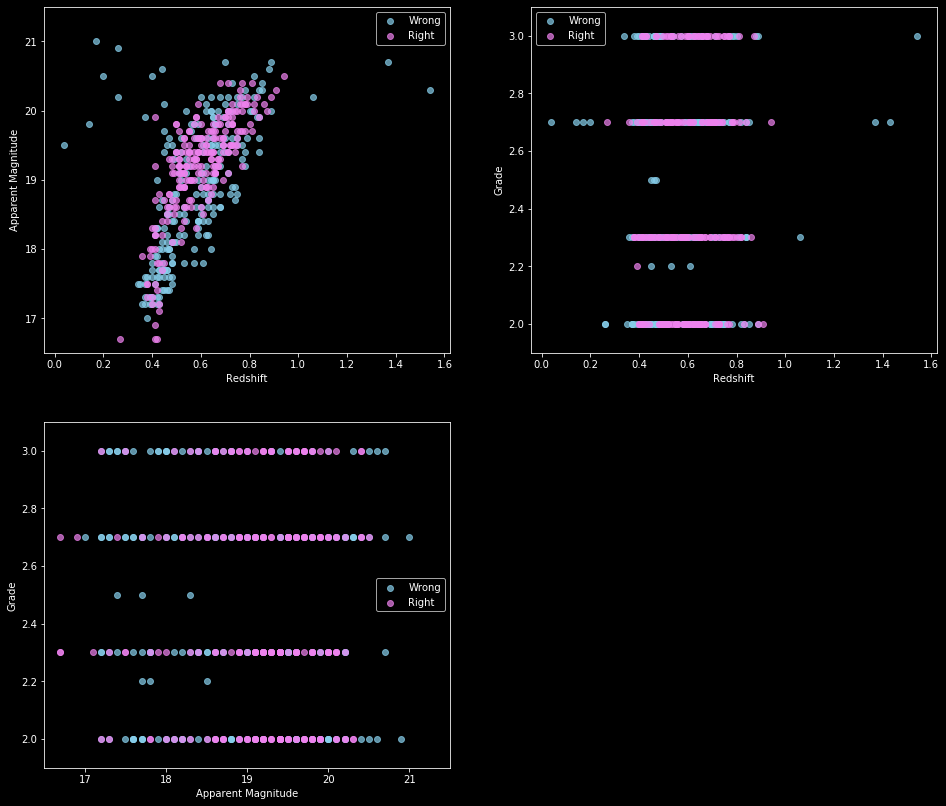

In [21]:
plt.figure(figsize=(16,14)) 

plt.subplot(2,2,1)
plt.xlabel('Redshift')
plt.ylabel('Apparent Magnitude')
plt.ylim(16.5,21.5)
plt.scatter(data_wrong_lenses['photoz'], data_wrong_lenses['imag'], color = 'skyblue', alpha = 0.7, label = 'Wrong')
plt.scatter(data_right_lenses['photoz'], data_right_lenses['imag'], color = 'violet', alpha = 0.7, label ='Right')
plt.legend()

plt.subplot(2,2,2)
plt.xlabel('Redshift')
plt.ylabel('Grade')
plt.ylim(1.9,3.1)
plt.scatter(data_wrong_lenses['photoz'], data_wrong_lenses['grade'], color = 'skyblue', alpha = 0.7, label = 'Wrong')
plt.scatter(data_right_lenses['photoz'], data_right_lenses['grade'], color = 'violet', alpha = 0.7, label ='Right')
plt.legend()

plt.subplot(2,2,3)
plt.xlabel('Apparent Magnitude')
plt.ylabel('Grade')
plt.xlim(16.5, 21.5)
plt.ylim(1.9,3.1)
plt.scatter(data_wrong_lenses['imag'], data_wrong_lenses['grade'], color = 'skyblue', alpha = 0.7, label = 'Wrong')
plt.scatter(data_right_lenses['imag'], data_right_lenses['grade'], color = 'violet', alpha = 0.7, label ='Right')
plt.legend()  
    
plt.show()